# Analysing data with Spark

A work by: Elliot Renel and Dorian Goepp.

## Downloading the data

Example command to download all the files for job events, running the downloads in parallel:

```bash
gsutil -m cp gs://clusterdata-2011-2/job_events/* ./job_events/
```

The parallelisation of the download is to take advantage of a high bandwidth internet connection. It would not help if the connection is slow.

As these are compressed with gzip, we need to un-compress them. There is an [easy way](https://stackoverflow.com/questions/16038087/extract-and-delete-all-gz-in-a-directory-linux) to do it for all files at once:

```bash
gunzip *.gz
```

> **Note:** As an afterthought, it might have been helpful to load the data directly from gzip files, saving some disk space at the cost of an increased computational load when a file is loaded.

## Parsing the schema file

The data we are working with is stored in CSV files of different "types", akin to tables in a relational database. Google provided a schema file (`schema.csv`) representing the fields of these CSV types.

To be able to make good use of the data, and to limit the risk of errors in selection of fields and handling of their format, we wrote a small python module to parse the schema file and help in loading and accessing the data in the CSV files.

In [1]:
# the Schema class of our utility module
from src.schema import Schema
# used to pretty-print tabular data
from tabulate import tabulate

Our module is used through an instance of the Schema class, as we will see later. The initialiser takes the path to the schema file provided by Google.

In [2]:
schema = Schema("data/schema.csv")

It is possible to print the object. This shows all the types of data in the data set. We commented the code block bellow as the output is quite verbose.

Note the `formatter` field. It is a function which will parse the input data and convert it to an appropriate Python type, based on the value in the `format` field of the schema.

In [3]:
# print(schema)

## Starting Spark

We use Spark locally, using all available cores.

In [4]:
from pyspark import SparkContext

# start spark with as many worker threads as available on the machine
sc = SparkContext("local[*]")
sc.setLogLevel("ERROR")

23/01/14 22:48:13 WARN Utils: Your hostname, Kixus-k resolves to a loopback address: 127.0.1.1; using 192.168.1.29 instead (on interface enx3c2c30d47db5)
23/01/14 22:48:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/14 22:48:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/01/14 22:48:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Analysis on machine events (Q1 & Q2)

The machine events files describe events that occurred to the machines in the cluster, as well as their specifications (mostly in the initial events).

First, let us see the schema of this file's data:

In [5]:
print(
    tabulate(
        schema.get_table_fields(
            'machine_events', include_formatters=False), headers='keys'))


  field number  content      format       mandatory
--------------  -----------  -----------  -----------
             0  time         INTEGER      True
             1  machine ID   INTEGER      True
             2  event type   INTEGER      True
             3  platform ID  STRING_HASH  False
             4  CPUs         FLOAT        False
             5  Memory       FLOAT        False


Let us now load the data in a Spark RDD. The `load_rdd` method from Schema does this for us. We give it the name of a table, and it fetches the related CSV files (if any) from the eponym folder in `data/`, here `data/machine_events`.

In [10]:
machine_events = schema.load_rdd(sc, 'machine_events')

A small sample of the data, to have an idea of how it looks:

In [11]:
print(tabulate(
	machine_events.take(5),
	headers=schema.get_table_field_names('machine_events'),
	maxcolwidths = [None, None, None, 15, None, None]))

  time    machine ID    event type  platform ID        CPUs    Memory
------  ------------  ------------  ---------------  ------  --------
     0             5             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=
     0             6             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=
     0             7             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=
     0            10             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=
     0            13             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy

The following will be used later to access fields of the data by their name instead of their index.

In [9]:
machine_events_get = schema.field_getters('machine_events')

### Distribution of CPU capacity (Q1)

We are looking for the distribution of machines according to their CPU capacity.

For this analysis, we only account for the machine creation events, and keep the latest such event for any given machine. The intent is to avoid registering any machine's CPU more than once, should it have been offline for some time.

Keeping the latest creation event is arbitrary, but considers that it is highly unlikely for a machine's CPU to be changed over time.

The first three operations on `machine_events` concern the extraction of machine creation events and the selection of one single creation event for any given machine.

The following three operations sums the numbers of machines with any given CPU capacity. We use the same method we were introduced to for words counting during the classes.

Distribution of machine capacity based on their CPU power (normalised):

In [13]:
from operator import add

cpu = machine_events_get['CPUs']
event_type = machine_events_get['event type']
machine_id = machine_events_get['machine ID']
time = machine_events_get['time']

cpu_usage = machine_events \
    .filter(lambda event: event_type(event) == 0 and cpu(event) is not None) \
    .map(lambda event: (machine_id(event),event)) \
    .reduceByKey(lambda r1,r2: r1 if time(r1)>time(r2) else r2) \
    .map(lambda row: (cpu(row[1]), 1)) \
    .reduceByKey(add) \
    .sortBy(lambda x: x[0])

for usage,nb in cpu_usage.collect():
    print(f"{nb} machines have CPU {usage}")


123 machines have CPU 0.25
11636 machines have CPU 0.5
796 machines have CPU 1.0


Here is a plot of the same data:

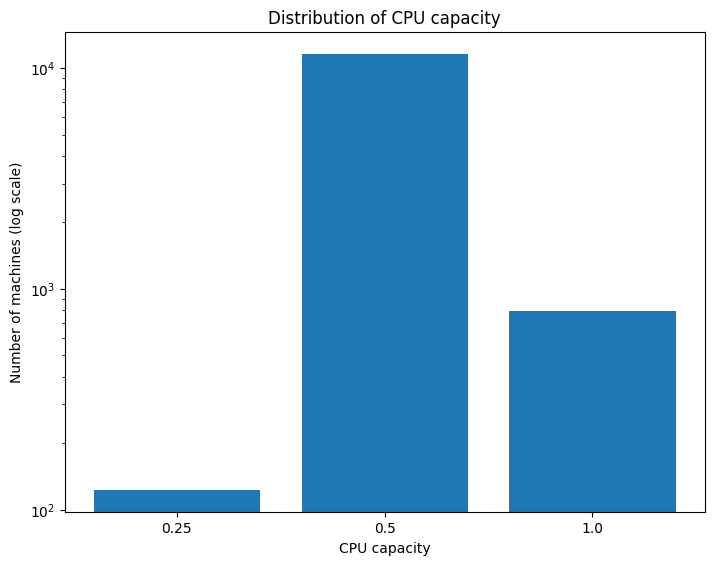

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
legend = cpu_usage.map(lambda x: str(x[0]) if x[0] is not None else 'None').collect()
count = cpu_usage.sortByKey().map(lambda x: x[1]).collect()
ax.bar(legend,count)

plt.xlabel("CPU capacity")
plt.ylabel("Number of machines (log scale)")
plt.title("Distribution of CPU capacity")

plt.yscale("log")
plt.show()

Please mind the y scale which is logarithmic, to better see the lesser frequent CPU capacities.

We observe that a vast majority of machines have half the maximum available CPU power. Less than ten times less machines have the full computational power and even less have a quarter of the maximal power.

### Lost Computational Power due to maintenance (Q2)

In [23]:
machines_history = machine_events \
    .map(lambda row: (machine_id(row),row)) \
    .aggregateByKey(None,lambda acc, e: acc+[e] if acc is not None else [e],add) \
    .map(lambda machine: machine[1])

for a_story in machines_history.take(3):
    print(tabulate(
        a_story,
        headers=schema.get_table_field_names('machine_events'),
        maxcolwidths = [None, None, None, 15, None, None]))
    print('\n')

  time    machine ID    event type  platform ID        CPUs    Memory
------  ------------  ------------  ---------------  ------  --------
     0             6             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=


         time    machine ID    event type  platform ID        CPUs    Memory
-------------  ------------  ------------  ---------------  ------  --------
            0            10             0  HofLGzk1Or/8Ild     0.5    0.2493
                                           j2+Lqv0UGGvY82N
                                           Loni8+J/Yy0RU=
1306164355566            10             1  HofLGzk1Or/8Ild     0.5    0.2493
                                           j2+Lqv0UGGvY82N
                                           Loni8+J/Yy0RU=
1307163081914            10             0  HofLGzk1Or/8Ild     0.5    0.2493
                                           j2+Lqv0UGGvY82N
       

In [10]:
machines_history.filter(lambda m: sorted(m)).count() - machines_history.count()

0

The trace period starts at 600 seconds (aka $6 \times 10^{8}$ microseconds), to obtain the total trace time, we find the latest event time and subtracted $6 \times 10^{8}$ to it.

In [11]:
from math import ceil

total_trace_time = time(machine_events.max(lambda row: time(row))) - 6*10**8

print(f'The total trace time is {total_trace_time} µs ≈ {ceil(total_trace_time/(10**6 * 3600))} hours ≈ {ceil(total_trace_time/(10**6 * 3600 * 24))} days')

The total trace time is 2505535493517 µs ≈ 696 hours ≈ 29 days


Once we have this number, computing the total computation power of a given machine is a matter of subtracting the starting time of the machine and multiplying by the CPU capacity. We assume here that the CPU capacity of a machine never changes, and we remove the machines that have some cpu values at None to prevent weird events.

In [12]:
def lost_and_total_power(events):
    # Functions and Variables
    status = machine_events_get['event type']
    time = machine_events_get['time']
    start = time(events[0])
    cpu = machine_events_get['CPUs'](events[0])

    # Lost time
    lost_time = 0
    for i,m in enumerate(events):
        if i==0:
            continue
        if status(m)==0 and status(events[i-1])==1:
            lost_time += time(m) - time(events[i-1])
        
    # Total time
    total_time = total_trace_time if (start < 6*10**8) else (total_trace_time - start + 6*10**8)

    # Resulting power
    return (lost_time*cpu,total_time*cpu)

def has_none_cpu(events):
    cpu = machine_events_get['CPUs']
    for m in events:
        if cpu(m) is None:
            return True
    return False

print(f'There are {machines_history.filter(has_none_cpu).count()} machines with None values in their CPUs. They will not be evaluated.')

power_lost_and_total = machines_history \
    .filter(lambda m: not has_none_cpu(m)) \
    .map(lost_and_total_power) \
    .reduce(lambda p1,p2: (p1[0]+p2[0],p1[1]+p2[1]))

print(f'During the trace time, around {(power_lost_and_total[0]/power_lost_and_total[1])*100:.4f}% of the computational power was lost.\
\nThe exact percentage obtained is {(power_lost_and_total[0]/power_lost_and_total[1])*100}% !')


There are 32 machines with None values in their CPUs. They will not be evaluated.
During the trace time, around 0.4798% of the computational power was lost.
The exact percentage obtained is 0.4798129882918588% !


## Distribution of jobs and tasks per scheduling class (Q3)

We will evaluate the distribution over **submitted** tasks and jobs. It also implies that we do not consider the distribution _over time_ but only within the _set_ of all submitted tasks and jobs.

We could also consider the evolution of the scheduling class through time, looking at the event types UPDATE_PENDING and UPDATE_RUNNING. This is a different perspective where time is a key component.

### Studying jobs

We start our analysis with jobs. They should be fewer, as there can be many tasks per job, but one job per task.

Before all, the schema for the tables we will use:

In [13]:
print(tabulate(schema.get_table_schema('job_events')['fields'], headers='keys', maxcolwidths=40))

  field number  content           format       mandatory    formatter
--------------  ----------------  -----------  -----------  --------------------------------------
             0  time              INTEGER      True         <function
                                                            parse_schema_line.<locals>.<lambda> at
                                                            0x7fa9debcc280>
             1  missing info      INTEGER      False        <function
                                                            parse_schema_line.<locals>.<lambda> at
                                                            0x7fa9debcd120>
             2  job ID            INTEGER      True         <function
                                                            parse_schema_line.<locals>.<lambda> at
                                                            0x7fa9debcc9d0>
             3  event type        INTEGER      True         <function
                          

First step, gather the events based on the task or job they refer to. We expect such lists of events to be small enough to be handled in regular python lists.

In [14]:
job_events = schema.load_rdd(sc,'job_events')
job_events.persist()

job_events_get = schema.field_getters('job_events')

print(tabulate(job_events.take(10)))

-------------    ----------  -  --------------------------------------------  -  --------------------------------------------  --------------------------------------------
1759537643559    6416951808  0  68CsCZngOkuQn5lVo+dNXKGoFx9ZmJXWR+W7NAUmEH4=  2  hsNjJ1kuW0Fjw19LCKSNMoIedO6dXEwotcAwuZzN+W8=  tjDJ4Yi7F2TEXAS8aMiOSj0Gnf0fMQU71fbn4Hh7YaQ=
1759537651487    6416951928  0  CyS0bJ1mSJjSSGuoHDUH9h1P9aCRWvC13/GWBPTKDWw=  2  BsI3s4eBz40Sw71oIDYmHa97gITSve44lxrA1wfeE80=  XJDU79m2icgPfbSC3t76/jDJ852+gvKUykoSUdjFzBo=
1759538717557    6416951928  1  CyS0bJ1mSJjSSGuoHDUH9h1P9aCRWvC13/GWBPTKDWw=  2  BsI3s4eBz40Sw71oIDYmHa97gITSve44lxrA1wfeE80=  XJDU79m2icgPfbSC3t76/jDJ852+gvKUykoSUdjFzBo=
1759538717561    6416951972  0  CyS0bJ1mSJjSSGuoHDUH9h1P9aCRWvC13/GWBPTKDWw=  2  aooVLhky98Hvzrvek0uHJVrpiG/T64405SdKVcrweOc=  bMH3deZyAJjfJKj5cwdPHB77S8p/ApWpTAaQR/uMGWc=
1759538717582    6416951808  1  68CsCZngOkuQn5lVo+dNXKGoFx9ZmJXWR+W7NAUmEH4=  2  hsNjJ1kuW0Fjw19LCKSNMoIedO6dXEwotcAwuZzN+W8=  tjDJ4Yi7F2TEX

In [15]:
print(f"There is an estimated {job_events.countApprox(10)} number of job events")

There is an estimated 2012242 number of job events


On Dorian's machine, the computation above took 1m 46s (with other running jobs such as browser and synchronisation service).

We are interested in the job submission event, which is when they are assigned their (initial) scheduling class.

In [16]:
# event type 0 = SUBMIT
scheduling_events = job_events \
    .filter(lambda job_event: job_events_get['event type'](job_event) == 0)

The documentation says that it is possible for a job to be submitted more than once, when it has evicted, failed or been killed but still is runnable (up to a maximal number of trials).

Do we have any such situation ?

In [17]:
jobs_with_several_scheduling_classes = scheduling_events \
    .map(lambda job_event: (job_events_get['job ID'](job_event), 
                            [job_events_get['scheduling class'](job_event)])) \
    .reduceByKey(lambda event1, event2: event1 + event2) \
    .filter(lambda x: len(x[1]) > 1) \
    .count()

print(f'{jobs_with_several_scheduling_classes} jobs have more than one scheduling class.')

1 jobs have more than one scheduling class.


No.

Let us then proceed with gathering the scheduling classes.

In [24]:
job_scheduling_classes = scheduling_events \
    .map(lambda event: (job_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .collect()

for scheduling_class in job_scheduling_classes:
    print(scheduling_class)

(0, 257276)
(1, 215109)
(2, 194513)
(3, 5177)


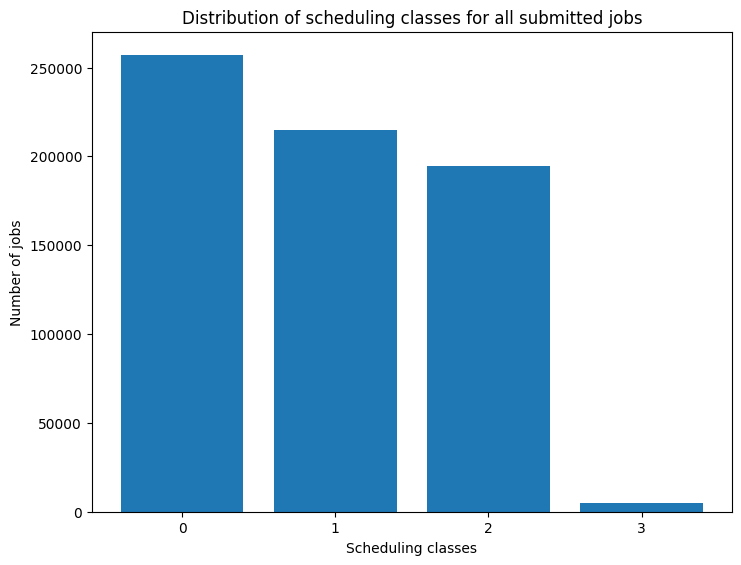

In [21]:
def bar_plot_question3(scheduling_classes, title):
    # TODO : make this into a proper function and put it in another file (plot.py ?)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    scheduling_class = list(map(lambda x: x[0], scheduling_classes))
    count = list(map(lambda x: x[1], scheduling_classes))
    ax.bar(scheduling_class,count)
    plt.xlabel("Scheduling classes")
    plt.ylabel("Number of jobs")
    plt.xticks(scheduling_class)
    plt.title(title)
    plt.show()

bar_plot_question3(job_scheduling_classes, "Distribution of scheduling classes for all submitted jobs")

### Repeating the analysis for tasks

Let us now do the same analysis for all tasks, irrespective of which job they belong to.

Starting with the schema of the tasks events table

In [18]:
task_events_get = schema.field_getters('task_events')

print(tabulate(
    schema.get_table_schema('task_events')['fields'], 
    headers='keys',
    maxcolwidths=[None, 20, None, None, 40]))

  field number  content             format       mandatory    formatter
--------------  ------------------  -----------  -----------  --------------------------------------
             0  time                INTEGER      True         <function
                                                              parse_schema_line.<locals>.<lambda> at
                                                              0x7f5ae5d82830>
             1  missing info        INTEGER      False        <function
                                                              parse_schema_line.<locals>.<lambda> at
                                                              0x7f5ae5d828c0>
             2  job ID              INTEGER      True         <function
                                                              parse_schema_line.<locals>.<lambda> at
                                                              0x7f5ae5d82a70>
             3  task index          INTEGER      True         <function
  

Then, we load the data and filter for submission events.

In [19]:
task_events = schema.load_rdd(sc,'task_events').persist()

task_submit_events = task_events.filter(
    lambda task_event: task_events_get['event type'](task_event) == 0)

# task_headers = map(lambda field: field['content'], task_events_schema['fields'])
# print(tabulate(task_submit_events.take(5), headers=task_headers))
for task_event in task_submit_events.take(5):
    print(task_event)

[0, 2, 3418309, 0, 4155527081, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, None, None, None, None]
[0, 2, 3418309, 1, 329150663, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, None, None, None, None]
[0, None, 3418314, 0, 3938719206, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, 0.125, 0.07446, 0.0004244, False]
[0, None, 3418314, 1, 351618647, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, 0.125, 0.07446, 0.0004244, False]
[0, 2, 3418319, 0, 431052910, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, None, None, None, None]


In [20]:
tasks_with_several_scheduling_classes = task_submit_events \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)), 
                        {task_events_get['scheduling class'](event)})) \
    .reduceByKey(lambda event1, event2: event1 | event2) \
    .filter(lambda x: len(x[1]) > 1)

print(f'{tasks_with_several_scheduling_classes.count()} tasks have more than one scheduling class.')

0 tasks have more than one scheduling class.


From this, we conclude that, as with jobs, no task has ever seen its scheduling class changed after being resubmitted (due to eviction, failure, kill).

In [21]:
task_scheduling_classes = task_submit_events \
    .map(lambda event: (task_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .collect()

for scheduling_class in task_scheduling_classes:
    print(scheduling_class)

(2, 47599)
(0, 98066)
(3, 28192)
(1, 27634)


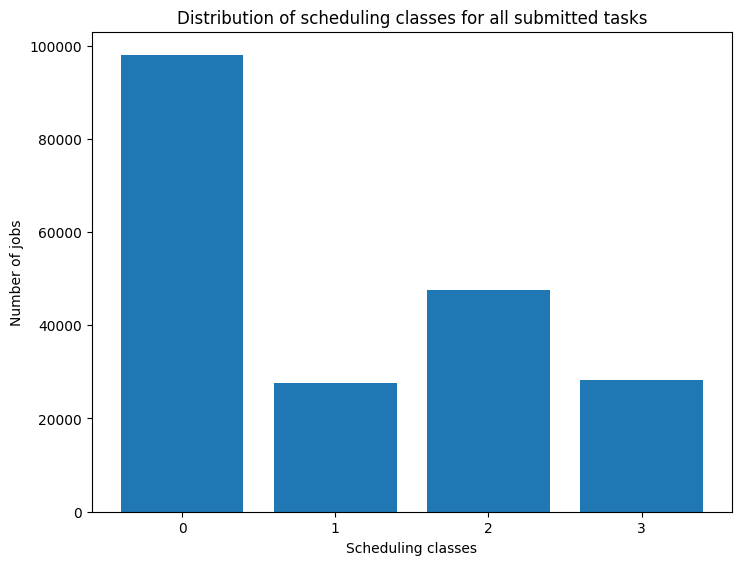

In [22]:
bar_plot_question3(task_scheduling_classes, "Distribution of scheduling classes for all submitted tasks")

## Relation between scheduling class and eviction of tasks (Q4)

In [23]:
scheduling_eviction_relations = task_events \
    .filter(lambda event: task_events_get['event type'](event) == 2) \
    .map(lambda event: (task_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .sortBy(lambda x: x[0])

for relations in scheduling_eviction_relations.collect():
    print(relations)

(0, 2864)
(1, 792)
(2, 662)
(3, 20)


Tasks with lower scheduling class were evicted much more than those with higher scheduling class. Note that we chose to keep all eviction events, even when a single task is evicted several times.

It matches the idea that latency-sensitive tasks, represented with higher scheduling classes, need to be interrupted (namely evicted) as little as possible, so that they can be completed soon.